In [1]:
import numpy as np
import roboticstoolbox as rtb
from spatialmath import SE3, SO3
from scipy.interpolate import CubicSpline
from roboticstoolbox.backends.swift import Swift
import matplotlib.pyplot as plt
import time
from spatialgeometry import Cuboid
import random

Robot in the envirnoment

In [2]:
env = Swift()

env.launch(realtime=True, comms="rtc")

panda = rtb.models.Panda()

# Define home configuration (ready pose, 7 joint angles in radians)
q_home = np.array([0, -np.pi/4, 0, -3*np.pi/4, 0, np.pi/2, np.pi/4])

env.add(panda)

terrain_bounds = {
    "x_min": 0.2, "x_max": 0.6,  # X range on the terrain
    "y_min": -0.8, "y_max": 0.8  # Y range on the terrain
}

# Create a colored plane to represent the reachable terrain
terrain = Cuboid(
    [terrain_bounds['x_max'] - terrain_bounds['x_min'], 
     terrain_bounds['y_max'] - terrain_bounds['y_min'], 
     0.001],  
    pose=SE3((terrain_bounds['x_min'] + terrain_bounds['x_max']) / 2, 
             (terrain_bounds['y_min'] + terrain_bounds['y_max']) / 2, 
             0),  # Centered at the middle of the bounds
    color=[0.5, 0.5, 0.5, 0.3]  # Light gray with transparency
)

env.add(terrain)

1

Objects in the environment

In [3]:
# Define cube dimensions and positions
cube_size = 0.06  
cube_height = cube_size
cube_center_z = cube_size / 2  

# Height for picking: top of the cube
pick_z = cube_center_z + cube_height / 2  

# Define pick and place positions for cubes
objects = {
    'red':    (np.array([0.5,  0.25, pick_z]), np.array([0.25, -0.35, pick_z])),
    'blue':   (np.array([0.5,  0.13, pick_z]), np.array([0.25, -0.47, pick_z])),
    'green':  (np.array([0.5,  0.01, pick_z]), np.array([0.25, -0.59, pick_z])),
    'yellow': (np.array([0.5, -0.11, pick_z]), np.array([0.25, -0.71, pick_z])),
}


print(f"Cube size: {cube_size}m")
print(f"Pick/Place height: z={pick_z:.3f}m")
print(f"Objects to sort: {len(objects)}")

for name, (pick, place) in objects.items():
    print(f"  {name}: pick={pick}, place={place}")

# Create visible cube objects in vertical line
bin_red = Cuboid([cube_size, cube_size, cube_size], 
                 pose=SE3(0.5, 0.25, cube_center_z), color=[1, 0, 0, 0.8])      
bin_blue = Cuboid([cube_size, cube_size, cube_size], 
                  pose=SE3(0.5, 0.13, cube_center_z), color=[0, 0, 1, 0.8])     
bin_green = Cuboid([cube_size, cube_size, cube_size], 
                   pose=SE3(0.5, 0.01, cube_center_z), color=[0, 1, 0, 0.8])    
bin_yellow = Cuboid([cube_size, cube_size, cube_size], 
                    pose=SE3(0.5, -0.11, cube_center_z), color=[1, 1, 0, 0.8])  


env.add(bin_red)
env.add(bin_blue)
env.add(bin_green)
env.add(bin_yellow)

print("Objects added to Swift in vertical line")

Cube size: 0.06m
Pick/Place height: z=0.060m
Objects to sort: 4
  red: pick=[0.5  0.25 0.06], place=[ 0.25 -0.35  0.06]
  blue: pick=[0.5  0.13 0.06], place=[ 0.25 -0.47  0.06]
  green: pick=[0.5  0.01 0.06], place=[ 0.25 -0.59  0.06]
  yellow: pick=[ 0.5  -0.11  0.06], place=[ 0.25 -0.71  0.06]
Objects added to Swift in vertical line


In [4]:
def generate_unique_positions(num_positions, bounds, min_distance, plate_center_z, plate_size):
    """Generate unique positions for objects within bounds."""
    positions = []
    attempts = 0
    max_attempts = 100  # Prevent infinite loops

    def is_within_bounds(position, bounds, plate_size):
        """Ensure the plate's center does not exceed the bounds."""
        x, y = position[:2]
        return (
            bounds['x_min'] + plate_size / 2 <= x <= bounds['x_max'] - plate_size / 2 and
            bounds['y_min'] + plate_size / 2 <= y <= bounds['y_max'] - plate_size / 2
        )

    while len(positions) < num_positions and attempts < max_attempts:
        new_pos = np.array([
            random.uniform(bounds['x_min'], bounds['x_max']),
            random.uniform(bounds['y_min'], bounds['y_max']),
            plate_center_z
        ])
        if (
            is_within_bounds(new_pos, bounds, plate_size) and
            all(np.linalg.norm(new_pos[:2] - pos[:2]) >= min_distance for pos in positions)
        ):
            positions.append(new_pos)
        attempts += 1

    if len(positions) < num_positions:
        raise ValueError("Could not generate enough unique positions within the bounds and constraints.")

    return positions

In [5]:
# Define the size and positions of the plates
plate_size = 0.1
plate_height = 0.005  
plate_center_z = plate_height / 2  # Center of the plate

# Generate unique positions for the plates
min_distance_between_plates = plate_size * 1.5  # Ensure plates don't overlap
plate_positions = generate_unique_positions(4, terrain_bounds, min_distance_between_plates, plate_center_z, plate_size)

plates = {
    'red': plate_positions[0],
    'blue': plate_positions[1],
    'green': plate_positions[2],
    'yellow': plate_positions[3],
}

# Create visible plate objects in the environment
plate_red = Cuboid([plate_size, plate_size, plate_height], 
                   pose=SE3(*plates['red']), color=[1, 0, 0, 0.5])      
plate_blue = Cuboid([plate_size, plate_size, plate_height], 
                    pose=SE3(*plates['blue']), color=[0, 0, 1, 0.5])     
plate_green = Cuboid([plate_size, plate_size, plate_height], 
                     pose=SE3(*plates['green']), color=[0, 1, 0, 0.5])    
plate_yellow = Cuboid([plate_size, plate_size, plate_height], 
                      pose=SE3(*plates['yellow']), color=[1, 1, 0, 0.5])  

env.add(plate_red)
env.add(plate_blue)
env.add(plate_green)
env.add(plate_yellow)

print("Plates added to Swift with randomized non-overlapping positions")

Plates added to Swift with randomized non-overlapping positions


# Compute the trajectory that the robot need to do for picking 

## Functions

non molto bene

In [6]:
def compute_ik(panda, position, z_offset=0.0): 
    """Compute IK for a position slightly above the object"""
    target = np.array(position).copy()
    target[2] += z_offset      
    
    pose = SE3(target[0], target[1], target[2]) * SE3.Rx(np.pi)
    
    result = panda.ikine_LM(pose, q0=q_home, joint_limits=True)
    return result.q, result.success


def make_traj(q_start, q_goal, duration=2.0, n_points=100):
    """Generate a smooth joint-space trajectory from q_start to q_goal."""
    t = np.linspace(0, duration, n_points)          # time vector
    traj = np.zeros((n_points, 7))                  # 7 joints
    
    for i in range(7):
        # cubic spline between start and goal for joint i
        cs = CubicSpline([0, duration], [q_start[i], q_goal[i]])
        traj[:, i] = cs(t)
    
    return traj


## Dictionary with trajectory

In [7]:
approach_height = 0.12 

trajectories = {}

for name, (pick_pos, _) in objects.items():
    # Get the plate position for placing
    place_pos = plates[name]

    # Adjust the cube's center to be above the plate by half the cube's height
    adjusted_place_pos = place_pos.copy()
    adjusted_place_pos[2] = max(plate_center_z + cube_height, adjusted_place_pos[2])

    # IK for approach and contact poses
    
    # Above pick and at pick
    q_pick_above, ok1 = compute_ik(panda, pick_pos, z_offset=approach_height)
    q_pick,       ok2 = compute_ik(panda, pick_pos, z_offset=0.0)
    
    # Above place and at place
    q_place_above, ok3 = compute_ik(panda, adjusted_place_pos, z_offset=approach_height)
    q_place,       ok4 = compute_ik(panda, adjusted_place_pos, z_offset=0.0)
    
    if not (ok1 and ok2 and ok3 and ok4):
        print(f"[ERROR] IK failed for {name}")
        continue

    # Joint-space trajectories for each phase
    traj_home_to_pick_above      = make_traj(q_home,        q_pick_above)
    traj_pick_above_to_pick      = make_traj(q_pick_above,  q_pick)
    traj_pick_to_pick_above      = make_traj(q_pick,        q_pick_above)
    traj_pick_above_to_place_abv = make_traj(q_pick_above,  q_place_above)
    traj_place_abv_to_place      = make_traj(q_place_above, q_place)
    traj_place_to_place_abv      = make_traj(q_place,       q_place_above)
    traj_place_abv_to_home       = make_traj(q_place_above, q_home)

    # Save everything in the dictionary
    trajectories[name] = {
        "home_to_pick_above":       traj_home_to_pick_above,
        "pick_above_to_pick":       traj_pick_above_to_pick,
        "pick_to_pick_above":       traj_pick_to_pick_above,
        "pick_above_to_place_abv":  traj_pick_above_to_place_abv,
        "place_abv_to_place":       traj_place_abv_to_place,
        "place_to_place_abv":       traj_place_to_place_abv,
        "place_abv_to_home":        traj_place_abv_to_home,
    }

## Do the movement

In [8]:
# Map each logical object name to its visual Cuboid in Swift
cube_objs = {
    'red': bin_red,
    'blue': bin_blue,
    'green': bin_green,
    'yellow': bin_yellow
}

In [9]:
def execute_pick_and_place(name, sleep_dt=0.02):
    """
    Execute the joint-space trajectories for one object and
    visually attach/detach the cube to the robot gripper.
    """
    cube = cube_objs[name]      # visual cube object
    trajs = trajectories[name]  # all phases for this object

    try:
        # 1) Home -> pick_above (robot approaches, cube stationary)
        for q in trajs["home_to_pick_above"]:
            panda.q = q
            env.step(0.01)
            time.sleep(sleep_dt)

        # 2) pick_above -> pick (descending, cube still stationary) 
        # Calculate the relative transformation hand->cube at the end
        last_q_contact = trajs["pick_above_to_pick"][-1]
        for q in trajs["pick_above_to_pick"]:
            panda.q = q
            env.step(0.01)
            time.sleep(sleep_dt)

        # Pose of the hand and cube at the moment of "contact"
        T_ee_contact   = panda.fkine(last_q_contact)  # end-effector pose at contact
        T_cube_contact = cube.T                       # cube pose on the table
        T_rel = T_ee_contact.inv() * T_cube_contact  # rigid transform hand -> cube

        # 3) pick -> pick_above (cube ATTACHED to the gripper) 
        for q in trajs["pick_to_pick_above"]:
            panda.q = q
            T_ee = panda.fkine(q)
            cube.T = T_ee * T_rel                    # cube follows the hand rigidly
            env.step(0.01)
            time.sleep(sleep_dt)

        # 4) pick_above -> place_above (transport in air with cube attached)
        for q in trajs["pick_above_to_place_abv"]:
            panda.q = q
            T_ee = panda.fkine(q)
            cube.T = T_ee * T_rel
            env.step(0.01)
            time.sleep(sleep_dt)

        # 5) place_above -> place (descending to place the cube)
        last_q_place = trajs["place_abv_to_place"][-1]
        for q in trajs["place_abv_to_place"]:
            panda.q = q
            T_ee = panda.fkine(q)
            cube.T = T_ee * T_rel
            env.step(0.01)
            time.sleep(sleep_dt)

        # Force the cube exactly into the place position
        place_pos = plates[name]  # Use the plate's position 
        cube.T = SE3(place_pos[0], place_pos[1], cube_center_z)

        # 6) place -> place_above (gripper rises, cube STAYS on the table) 
        for q in trajs["place_to_place_abv"]:
            panda.q = q
            # Do not update cube.T: the cube stays where we left it
            env.step(0.01)
            time.sleep(sleep_dt)

        # 7) place_above -> home (robot returns to home)
        for q in trajs["place_abv_to_home"]:
            panda.q = q
            env.step(0.01)
            time.sleep(sleep_dt)

    except Exception as e:
        print(f"[ERROR] Failed to execute pick-and-place for {name}: {e}")

In [10]:
for name in trajectories.keys():
    print(f"[INFO] Executing pick-and-place for {name}")
    execute_pick_and_place(name, sleep_dt=0.02)

[INFO] Executing pick-and-place for red
[INFO] Executing pick-and-place for blue
[INFO] Executing pick-and-place for green
[INFO] Executing pick-and-place for yellow


KeyboardInterrupt: 

## Visualization Plots


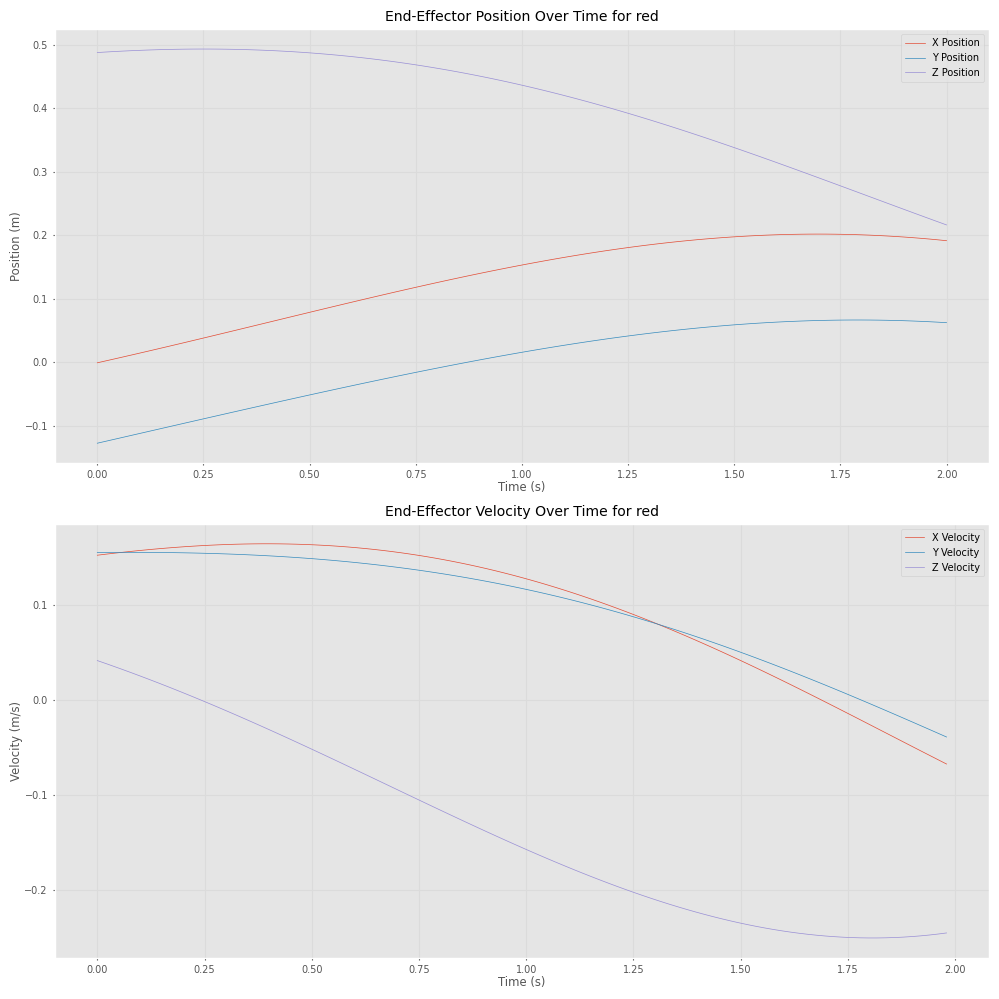

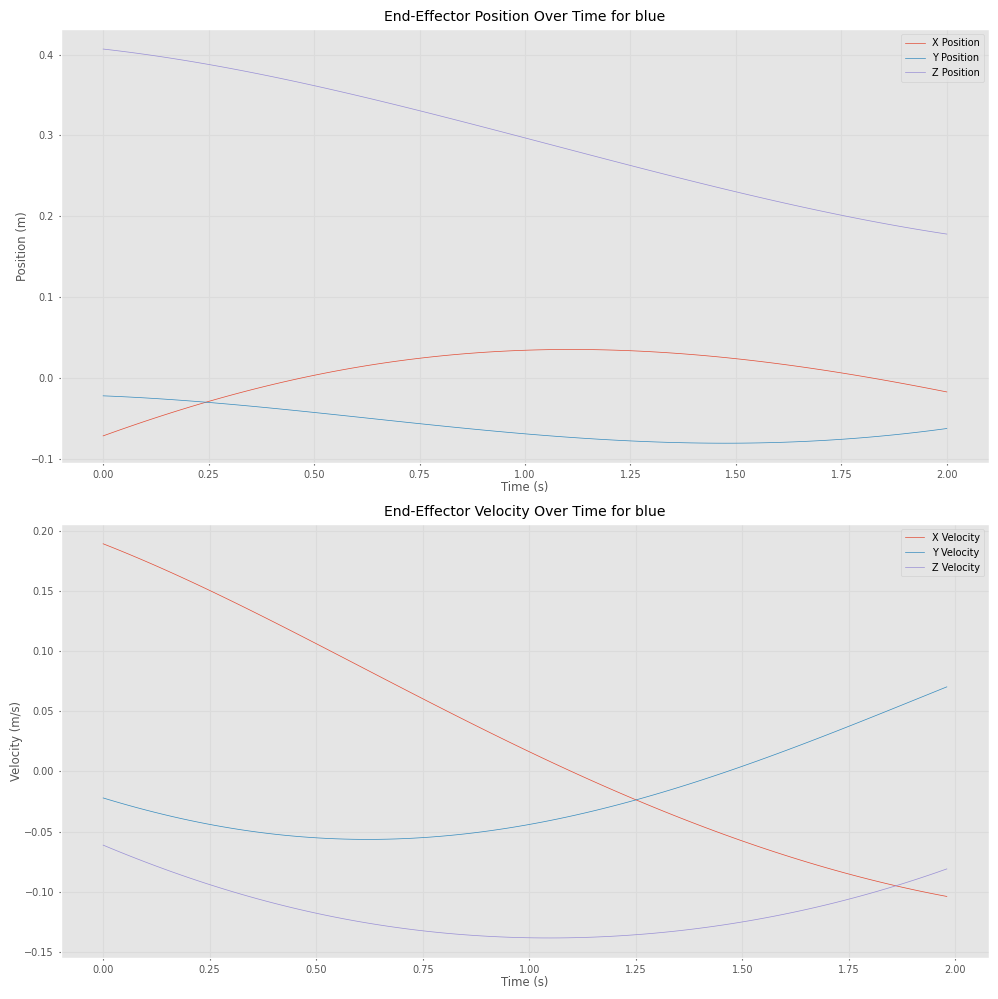

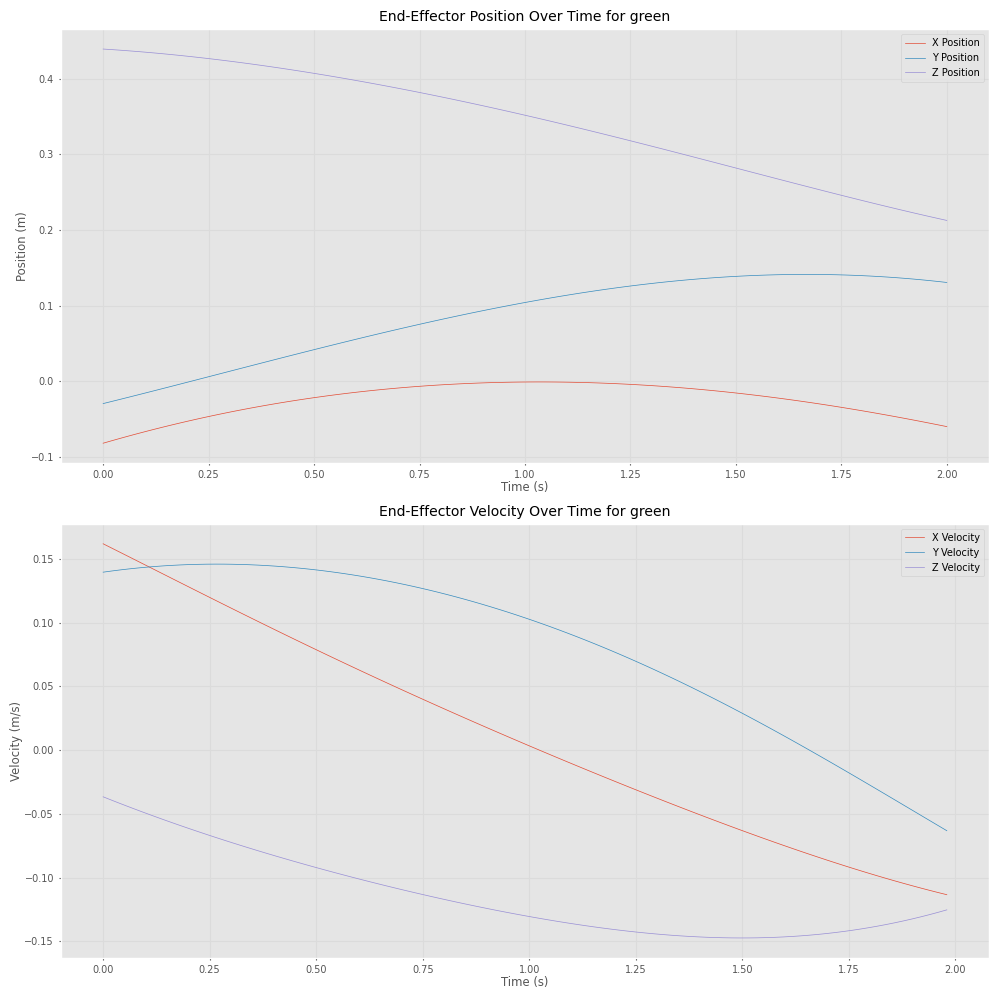

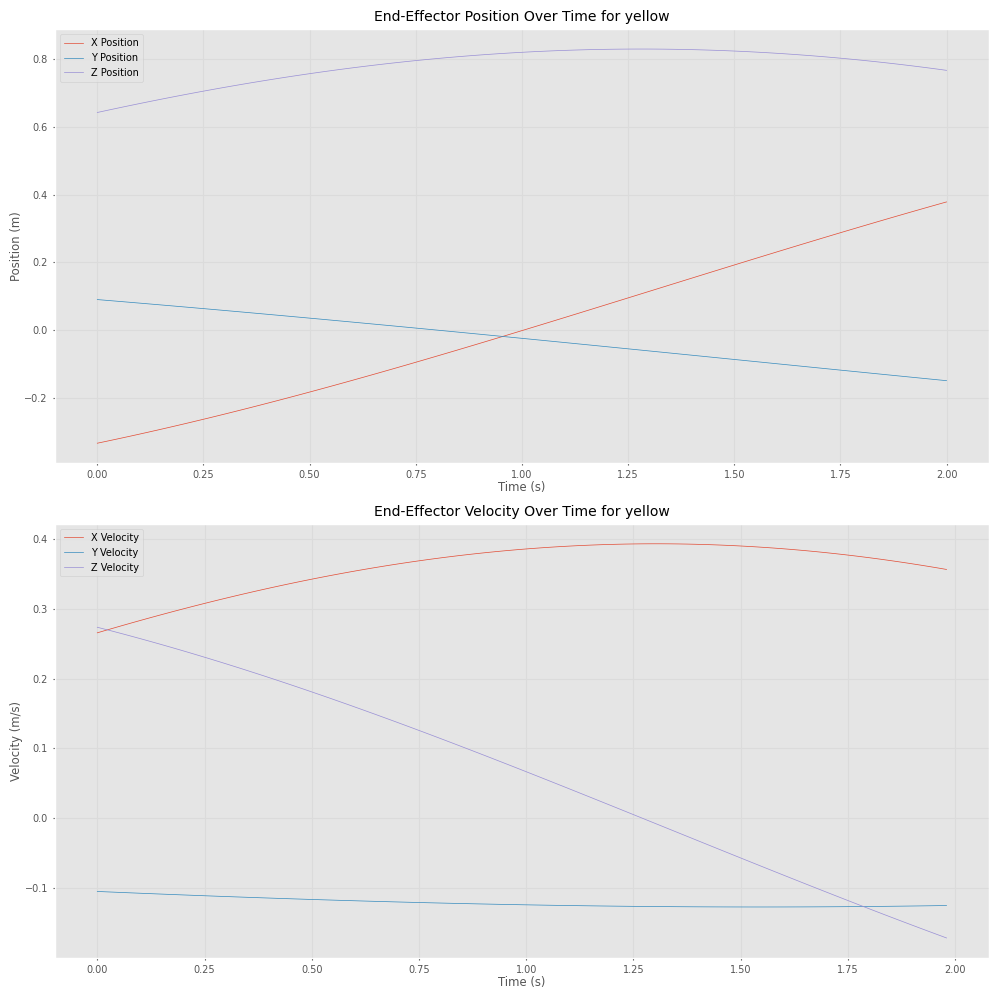

In [11]:
import matplotlib.pyplot as plt

def plot_ee_position_velocity(trajectories, panda):
    """Plot time vs end-effector position and velocity."""
    for name, traj_dict in trajectories.items():
        # Combine all trajectories into one continuous motion
        combined_trajectory = (
            traj_dict["home_to_pick_above"] +
            traj_dict["pick_above_to_pick"] +
            traj_dict["pick_to_pick_above"] +
            traj_dict["pick_above_to_place_abv"] +
            traj_dict["place_abv_to_place"]
        )

        ee_positions = []
        for q in combined_trajectory:
            ee_pose = panda.fkine(q)  # Forward kinematics to get end-effector pose
            ee_positions.append(ee_pose.t)  # Extract translation (x, y, z)

        ee_positions = np.array(ee_positions)
        time_steps = np.linspace(0, len(ee_positions) * 0.02, len(ee_positions))  # Assuming 0.02s per step

        # Compute velocities as differences between consecutive positions
        ee_velocities = np.diff(ee_positions, axis=0) / 0.02  # Velocity = Δposition / Δtime

        # Plot position
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))
        axs[0].plot(time_steps, ee_positions[:, 0], label="X Position")
        axs[0].plot(time_steps, ee_positions[:, 1], label="Y Position")
        axs[0].plot(time_steps, ee_positions[:, 2], label="Z Position")
        axs[0].set_title(f"End-Effector Position Over Time for {name}")
        axs[0].set_xlabel("Time (s)")
        axs[0].set_ylabel("Position (m)")
        axs[0].legend()
        axs[0].grid(True)

        # Plot velocity
        velocity_time_steps = time_steps[:-1]  # One less due to differentiation
        axs[1].plot(velocity_time_steps, ee_velocities[:, 0], label="X Velocity")
        axs[1].plot(velocity_time_steps, ee_velocities[:, 1], label="Y Velocity")
        axs[1].plot(velocity_time_steps, ee_velocities[:, 2], label="Z Velocity")
        axs[1].set_title(f"End-Effector Velocity Over Time for {name}")
        axs[1].set_xlabel("Time (s)")
        axs[1].set_ylabel("Velocity (m/s)")
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

plot_ee_position_velocity(trajectories, panda)

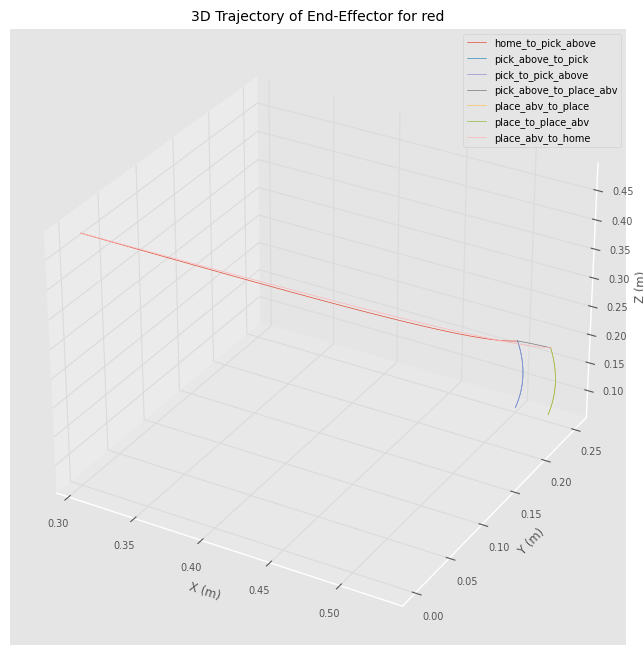

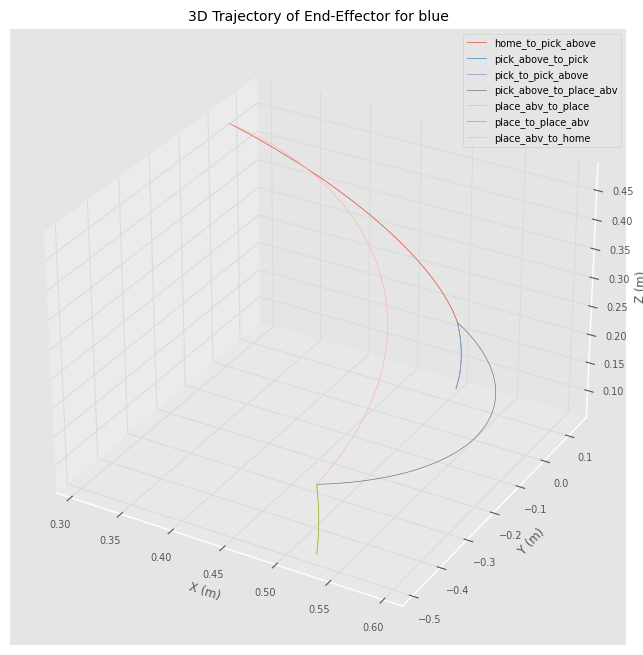

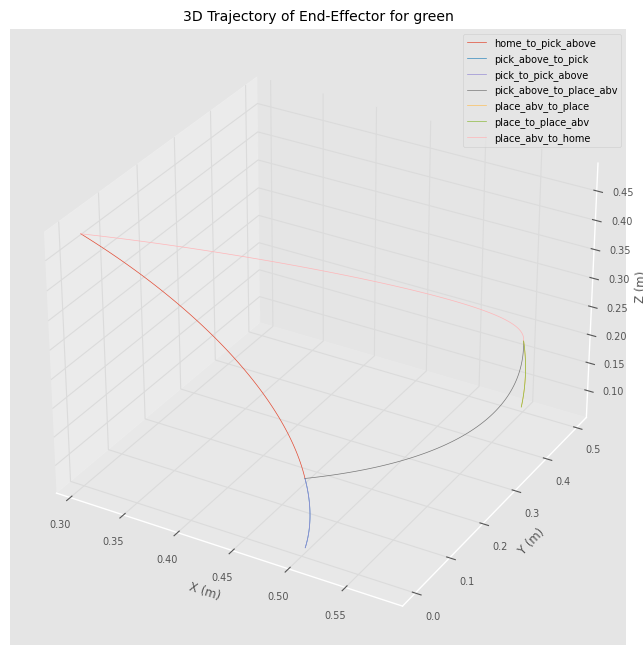

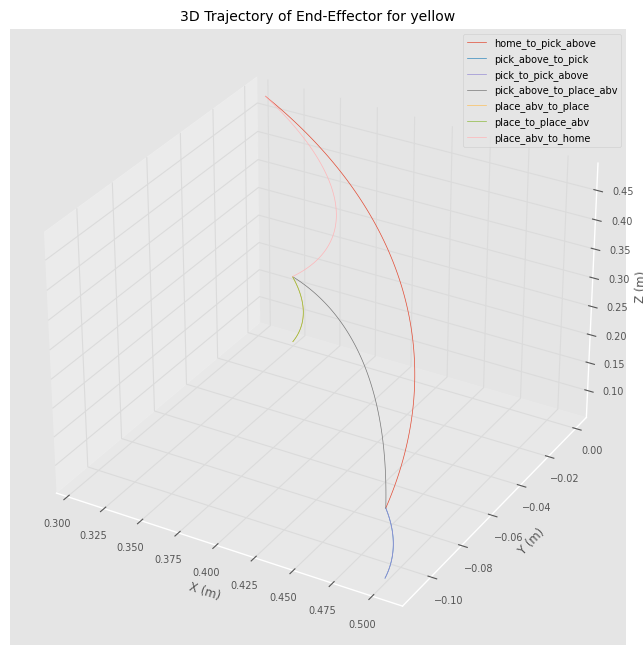

In [12]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_trajectory_per_cube(trajectories, panda):
    """Plot the 3D trajectory of the robot's end-effector for each cube without combining trajectories."""
    for name, traj_dict in trajectories.items():
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        for phase, traj in traj_dict.items():
            ee_positions = []
            for q in traj:
                ee_pose = panda.fkine(q) 
                ee_positions.append(ee_pose.t) 

            ee_positions = np.array(ee_positions)
            ax.plot(ee_positions[:, 0], ee_positions[:, 1], ee_positions[:, 2], label=phase)

        ax.set_title(f"3D Trajectory of End-Effector for {name}")
        ax.set_xlabel("X (m)")
        ax.set_ylabel("Y (m)")
        ax.set_zlabel("Z (m)")
        ax.legend()
        plt.show()

plot_3d_trajectory_per_cube(trajectories, panda)